In [1]:
import os
import numpy as np
import cv2
import glob
import itertools
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from shutil import copy, copyfile

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline

In [2]:
test_images_path = "./data/test/"
test_segs_path = "./data/testmask/"
test_pred_path = "./data/testpredictions/"
test_pred_aug_path = "./data/testpredictionsaug/"

train_images_path = "./data/train/"
train_segs_path = "./data/trainmask/"
train_batch_size = 6

val_images_path = "./data/val/"
val_segs_path = "./data/valmask/"

n_classes = 2

** Read training set **

In [4]:
images = glob.glob(val_images_path + "*.png")
segmentations = glob.glob(val_segs_path + "*.png")

images.sort()
segmentations.sort()

assert len(images) == len(segmentations) != 0

In [5]:
X_train = []
y_train = []

for img, seg in zip(images, segmentations):
    assert (img.split('/')[-1].split(".")[0] == 
            seg.split('/')[-1].split(".")[0])
    
    X_train.append(cv2.cvtColor(cv2.imread(img, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
    y_train.append(cv2.imread(seg, cv2.IMREAD_GRAYSCALE))
    
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train.shape, y_train.shape

((20, 482, 482, 3), (20, 482, 482))

** Read test set and predictions **

In [6]:
images = glob.glob(test_images_path + "*.png")
segmentations = glob.glob(test_segs_path + "*.png")
predictions = glob.glob(test_pred_path + "*.png")

images.sort()
segmentations.sort()
predictions.sort()

assert len(images) == len(segmentations) == len(predictions) !=0

In [7]:
X_test = []
y_test = []
y_pred = []

for img, seg, pred in zip(images, segmentations, predictions):
    assert (img.split('/')[-1].split(".")[0] == 
            seg.split('/')[-1].split(".")[0] == 
            pred.split('/')[-1].split(".")[0])
    
    X_test.append(cv2.cvtColor(cv2.imread(img, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
    y_test.append(cv2.imread(seg, cv2.IMREAD_GRAYSCALE))
    y_pred.append(cv2.imread(pred, cv2.IMREAD_GRAYSCALE))
    
X_test = np.array(X_test)
y_test = np.array(y_test)
y_pred = np.array(y_pred)

X_test.shape, y_test.shape, y_pred.shape

((25, 482, 482, 3), (25, 482, 482), (25, 224, 224))

In [8]:
augmented_predictions = glob.glob(test_pred_aug_path + "*.png")
augmented_predictions.sort()

assert len(images) == len(augmented_predictions) !=0

y_pred_aug = []

for img, pred_aug in zip(images, augmented_predictions):
    assert (img.split('/')[-1].split(".")[0] == pred_aug.split('/')[-1].split(".")[0])
    y_pred_aug.append(cv2.imread(pred_aug, cv2.IMREAD_GRAYSCALE))
    
y_pred_aug = np.array(y_pred_aug)
y_pred_aug.shape

(25, 224, 224)

** Visually check one image and its mask **

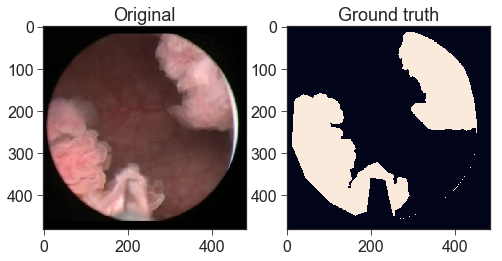

In [9]:
plt.rcParams['figure.figsize'] = (8, 8)

ind = 7

plt.subplot(121);
plt.imshow(X_test[ind, :, :, :]);
plt.title("Original");

plt.subplot(122);
plt.imshow(y_test[ind, :, :]);
plt.title("Ground truth");

** Visually check masks in the whole dataset **

In [10]:
ind = [0, 1, 2, 3]

[4, 5, 6, 7]


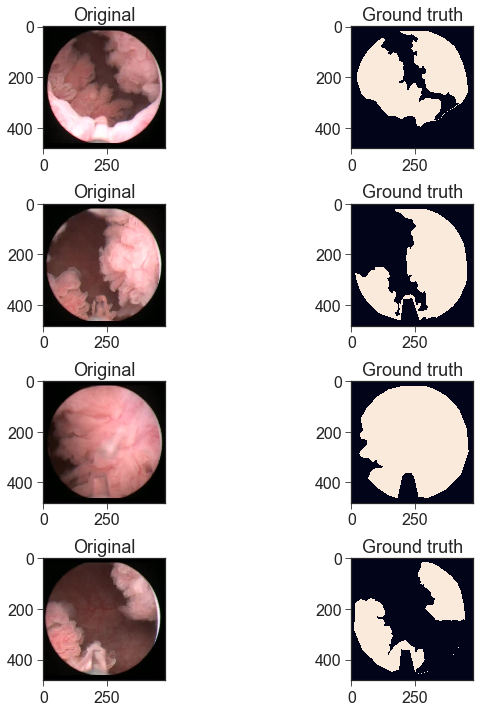

In [11]:
plt.rcParams['figure.figsize'] = (10, 10)
ind = [x + 4 for x in ind]
print(ind)

for i in range(len(ind)):
    plt.subplot(421 + 2*i)
    plt.imshow(X_test[ind[i], :, :, :]);
    plt.title("Original");

    plt.subplot(422 + 2*i)
    plt.imshow(y_test[ind[i], :, :]);
    plt.title("Ground truth");

plt.tight_layout();

** One prediction **

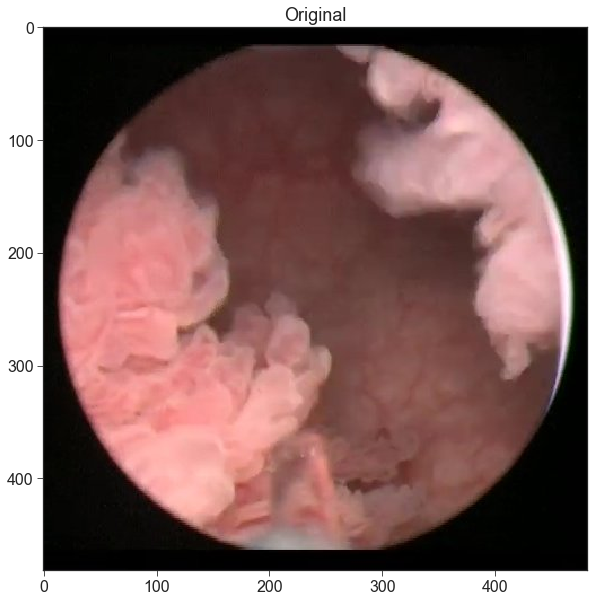

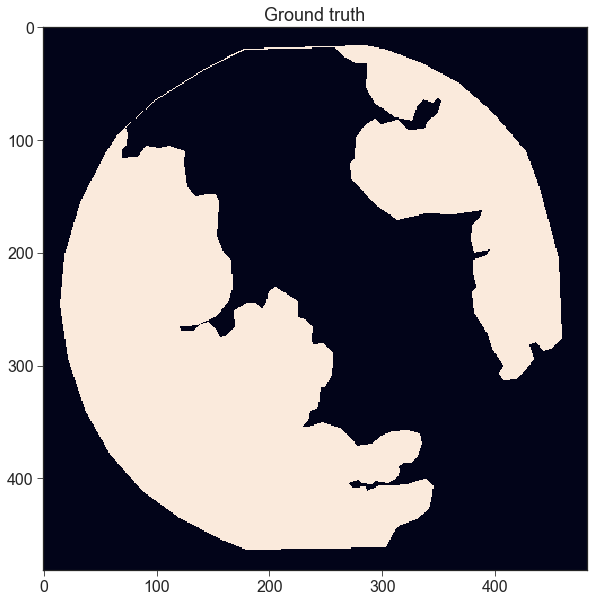

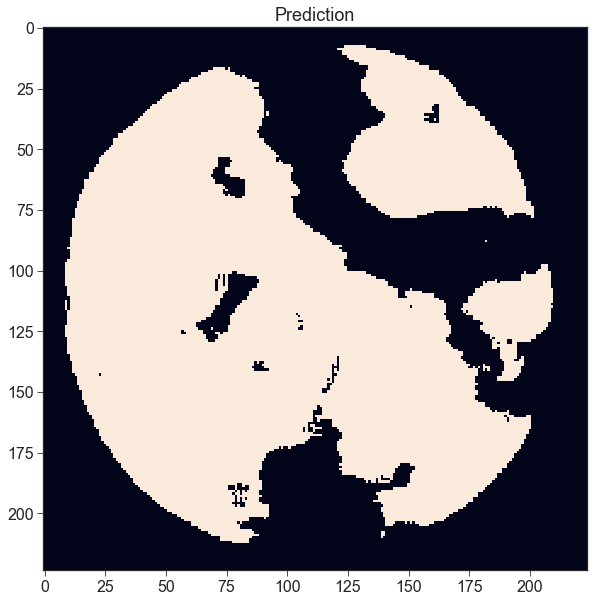

In [14]:
ind = 2

plt.figure();
plt.imshow(X_test[ind, :, :, :]);
plt.title("Original");

plt.figure();
plt.imshow(y_test[ind, :, :]);
plt.title("Ground truth");

plt.figure();
plt.imshow(y_pred[ind, :, :]);
plt.title("Prediction");

** Compare predictions from two models **

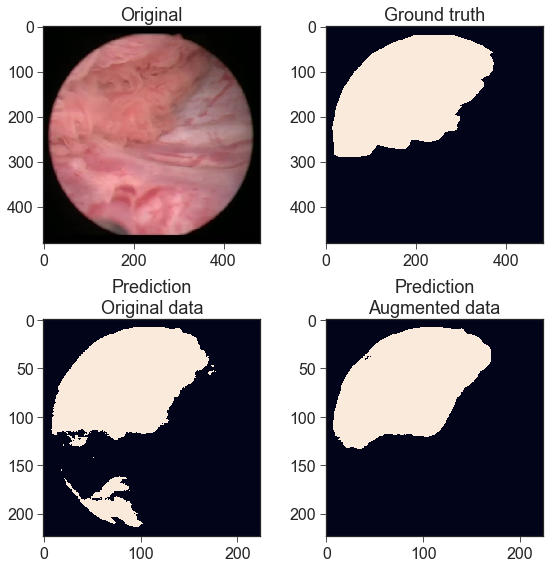

In [15]:
ind = 23
plt.rcParams['figure.figsize'] = (8, 8)

plt.subplot(221)
plt.imshow(X_test[ind, :, :, :]);
plt.title("Original");

plt.subplot(222)
plt.imshow(y_test[ind, :, :]);
plt.title("Ground truth");

plt.subplot(223)
plt.imshow(y_pred[ind, :, :]);
plt.title("Prediction\nOriginal data");

plt.subplot(224)
plt.imshow(y_pred_aug[ind, :, :]);
plt.title("Prediction\nAugmented data");
plt.tight_layout();

** Create pretty overlays **

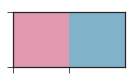

In [29]:
colors = [(0.884, 0.606, 0.682), (0.502, 0.704, 0.79)]
sns.palplot(colors)
colors = (np.asarray(colors)*255).astype('uint8')

In [20]:
def pretty_plots(img, seg_img, pred_img, loc=(240, 245), save=True):
    ## Original image
    fig, ax = plt.subplots(figsize=(5, 5))

    patch = patches.Circle(loc, radius=240, transform=ax.transData)
    im1 = ax.imshow(img);
    im1.set_clip_path(patch)
    plt.axis("off");
    plt.title("Original");
    if save:
        plt.savefig('../../materials/results/test_' + str(ind) + '.png', bbox_inches='tight', dpi=300);

    ## Original image + ground truth

    fig, ax = plt.subplots(figsize=(5, 5))

    patch = patches.Circle(loc, radius=240, transform=ax.transData)
    im1 = ax.imshow(img);
    im1.set_clip_path(patch)
    im2 = ax.imshow(seg_img, alpha=0.5)
    im2.set_clip_path(patch)
    plt.axis("off");
    plt.title("Ground truth");
    if save:
        plt.savefig('../../materials/results/test_' + str(ind) + '_gt.png', bbox_inches='tight', dpi=300);

    ## Original image + prediction

    fig, ax = plt.subplots(figsize=(5, 5))

    patch = patches.Circle(loc, radius=240, transform=ax.transData)
    im1 = ax.imshow(img);
    im1.set_clip_path(patch)
    im3 = ax.imshow(pred_img, alpha=0.5)
    im3.set_clip_path(patch)
    plt.axis("off");
    plt.title("Prediction");
    if save:
        plt.savefig('../../materials/results/test_' + str(ind) + '_pred.png', bbox_inches='tight', dpi=300);

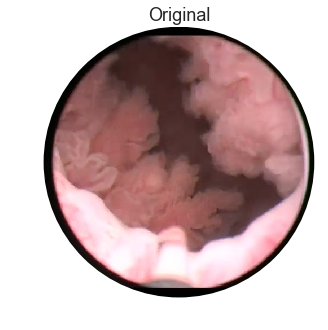

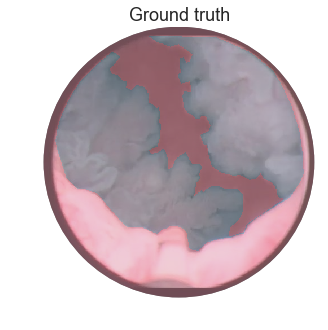

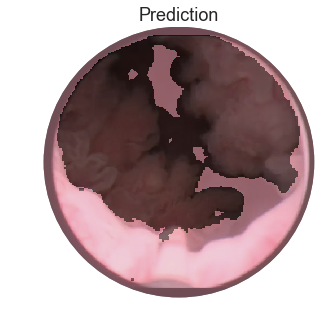

In [32]:
ind = 4

img = X_test[ind].copy()
seg = y_test[ind].copy()
pred = y_pred[ind].copy()

pred = cv2.resize(pred, seg.shape)

seg_img = np.zeros((seg.shape + (3,)), dtype=np.uint8)
pred_img = np.zeros_like(seg_img)

for c in range(n_classes):
    seg_img[seg == c] += colors[c]
    pred_img[pred == c] += colors[c]

pretty_plots(img, seg_img, pred_img, loc=(240,240), save=False)

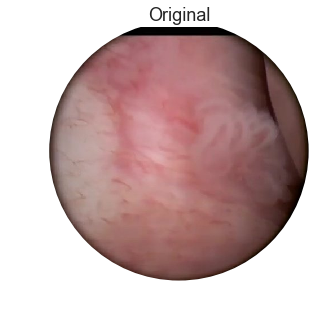

In [22]:
ind = 3

img = X_train[ind].copy()
fig, ax = plt.subplots(figsize=(5, 5))

patch = patches.Circle((240, 220), radius=230, transform=ax.transData)
im1 = ax.imshow(img);
im1.set_clip_path(patch)
plt.axis("off");
plt.title("Original");
# plt.savefig('../../materials/results/train_original.png', bbox_inches='tight', dpi=300);

In [23]:
colors = np.array([[50,50,50], [240,240,240]]).astype('uint8')

In [24]:
seg = y_train[ind].copy()

seg_img = np.zeros((seg.shape + (3,)), dtype=np.uint8)

for c in range(n_classes):
    seg_img[seg == c] += colors[c]

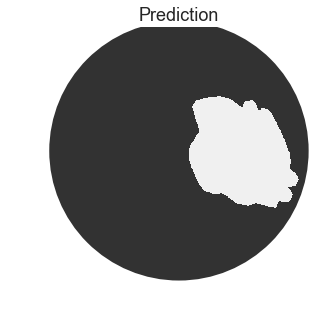

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))

patch = patches.Circle((240, 220), radius=230, transform=ax.transData)
im2 = ax.imshow(seg_img)
im2.set_clip_path(patch)
plt.axis("off");
plt.title("Prediction");
# plt.savefig('../../materials/results/train_mask.png', bbox_inches='tight', dpi=300);